In [2]:
import pandas as pd

In [4]:
data = pd.read_csv('data/cancer.csv').applymap(lambda x: x.lower())
data.columns = data.columns.str.lower()
data

,shape,size,color,surface,thickness,target
0,circular,large,light,smooth,thick,yes
1,circular,large,light,irregular,thick,yes
2,oval,large,dark,smooth,thin,no
3,oval,large,light,irregular,thick,yes


In [3]:
# consistency constrain
def const1(a,b):
    return a == "?"or (a != "0" and (a == b or b == "0"))

def isconsistent(h,d):
    return all(const1(a,b) for a,b in zip(h,d))

def minimal_generalize(h,d):
    for i in range(len(h)):
        if not isconsistent(h[i:i+1],d[i:i+1]):
            h[i] = d[i] if h[i] == "0" else "?"
    return [tuple(h)]

def minimal_specialization(h,domains,d):
    special = []
    for i in range(len(h)):
        if h[i] == "?":
            for val in domains[i]:
                if d[i] != val:
                    h_new = h[:i] + (val,) + h[i+1:]
                    special.append(h_new)
        elif h[i] != "0":
            h_new = h[:i] + ('0',) + h[i+1:]
            special.append(h_new)
    return special

def more_general(A,B,skip=True):
    if isinstance(B,set):
        return any(isconsistent(A,h) if A != h else skip for h in B)
    if isinstance(A,set):
        return any(isconsistent(h,B) if B != h else skip for h in A)
    

## Candidate Elimination Algorithm
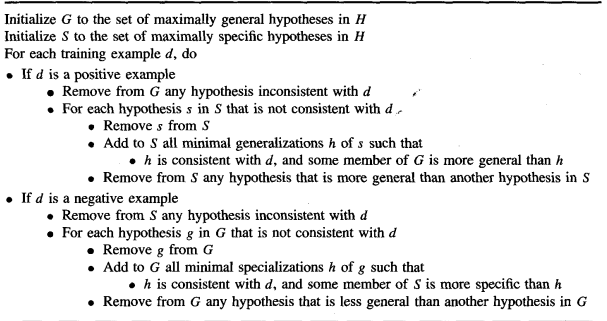

In [4]:
def candidate_elimination(data):
    
    domains = [data[column].unique().tolist() for column in data.columns[:-1]]
    N = len(data.columns[:-1])
    G = set([('?',)*N])
    S = set([('0',)*N])
    i = 0
    for d in data.values:
        d, c = d[:-1], d[-1]
        print(f"S[{i}]: {S}")
        print(f"G[{i}]: {G}\n")
        i+=1
        if c == "yes":
            G = {g for g in G if isconsistent(g,d)}
            set_S = list(S)
            for s in set_S:
                if s not in S: continue
                if not isconsistent(s,d):
                    S.remove(s)
                    min_g = minimal_generalize(list(s),d)
                    S.update([h for h in min_g if more_general(G,h)])
                    S.difference_update([s for s in S if more_general(s,S,False)])
        else:
            S = {s for s in S if not isconsistent(s,d)}
            set_G = list(G)
            for g in set_G:
                if g not in G: continue
                if isconsistent(g,d):
                    G.remove(g)
                    min_s = minimal_specialization(g,domains,d)
                    G.update([h for h in min_s if more_general(h,S)])
                    G.difference_update([g for g in G if more_general(G,g,False)])
    
    print(f"S[{i}]: {S}")
    print(f"G[{i}]: {G}\n")
    return S, G

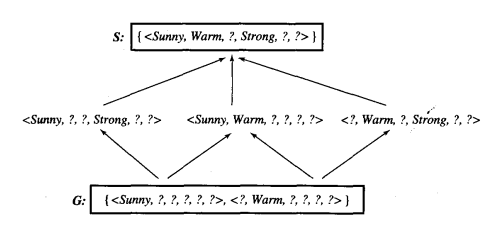

In [5]:
def generate_version_space(S,G):
    VS = set()
    for s in S:
        for g in G:
            for i in range(len(g)):
                if g[i] == "?" and s[i] != "?": VS.add(g[:i]+(s[i],)+g[i+1:])
    return VS
    

In [6]:
S,G = candidate_elimination(data)

VS = generate_version_space(S,G)

print(f"Version Space:\n\tSpecific: {S}\n{VS}\n\tGenearl: {G}")

S[0]: {('0', '0', '0', '0', '0')}
G[0]: {('?', '?', '?', '?', '?')}

S[1]: {('circular', 'large', 'light', 'smooth', 'thick')}
G[1]: {('?', '?', '?', '?', '?')}

S[2]: {('circular', 'large', 'light', '?', 'thick')}
G[2]: {('?', '?', '?', '?', '?')}

S[3]: {('circular', 'large', 'light', '?', 'thick')}
G[3]: {('?', '?', 'light', '?', '?'), ('circular', '?', '?', '?', '?'), ('?', '?', '?', '?', 'thick')}

S[4]: {('?', 'large', 'light', '?', 'thick')}
G[4]: {('?', '?', 'light', '?', '?'), ('?', '?', '?', '?', 'thick')}

Version Space:
	Specific: {('?', 'large', 'light', '?', 'thick')}
{('?', '?', 'light', '?', 'thick'), ('?', 'large', 'light', '?', '?'), ('?', 'large', '?', '?', 'thick')}
	Genearl: {('?', '?', 'light', '?', '?'), ('?', '?', '?', '?', 'thick')}
